Ovaj skup sadrzi dve serije podataka o nivou prizemnog ozona. Jedna se odnosi na osmocasovni maksimum (eight-hour peak set – eighthr.data), a druga na jednocasovni maksimum (one-hour peak set – onehr.data). Podaci su prikupljani u periodu od 1998. do 2004. godine na podrucju Houston–Galveston–Brazoria u Teksasu, SAD.

Za potrebe ovog projekta trenutno se koristi jednocasovni skup podataka (one-hour peak set). Trenutno je veci fokus usmeren na analizu temperature i njen odnos sa drugim parametrima, posto u ovim podacima vrednost ozona je samo 1 ili 0 u zavisnosti da li prelazi neki threshold i pritom ima malo vrednosti gde je zapravo 1.

Import biblioteka

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier 
from sklearn.neural_network import MLPClassifier 
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

Faza 1

Import fajla i formatiranje podataka

In [4]:
file = 'ozone/onehr.data'
data = pd.read_csv(file, header=None)

columns = [
    'Date',
    'WSR0','WSR1','WSR2','WSR3','WSR4','WSR5','WSR6','WSR7','WSR8','WSR9','WSR10','WSR11','WSR12','WSR13','WSR14','WSR15','WSR16','WSR17','WSR18','WSR19','WSR20','WSR21','WSR22','WSR23',
    'WSR_PK','WSR_AV',
    'T0','T1','T2','T3','T4','T5','T6','T7','T8','T9','T10','T11','T12','T13','T14','T15','T16','T17','T18','T19','T20','T21','T22','T23',
    'T_PK','T_AV',
    'T85','RH85','U85','V85','HT85',
    'T70','RH70','U70','V70','HT70',
    'T50','RH50','U50','V50','HT50',
    'KI','TT','SLP','SLP_','Precp','Class',
]

data.columns = columns

num_cols = data.columns.difference(['Date', 'Class'])
data[num_cols] = data[num_cols].apply(
    lambda s: pd.to_numeric(s, errors='coerce')
)





Prikaz podataka:

C:\Users\User\AppData\Local\Temp\ipykernel_13732\96490037.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


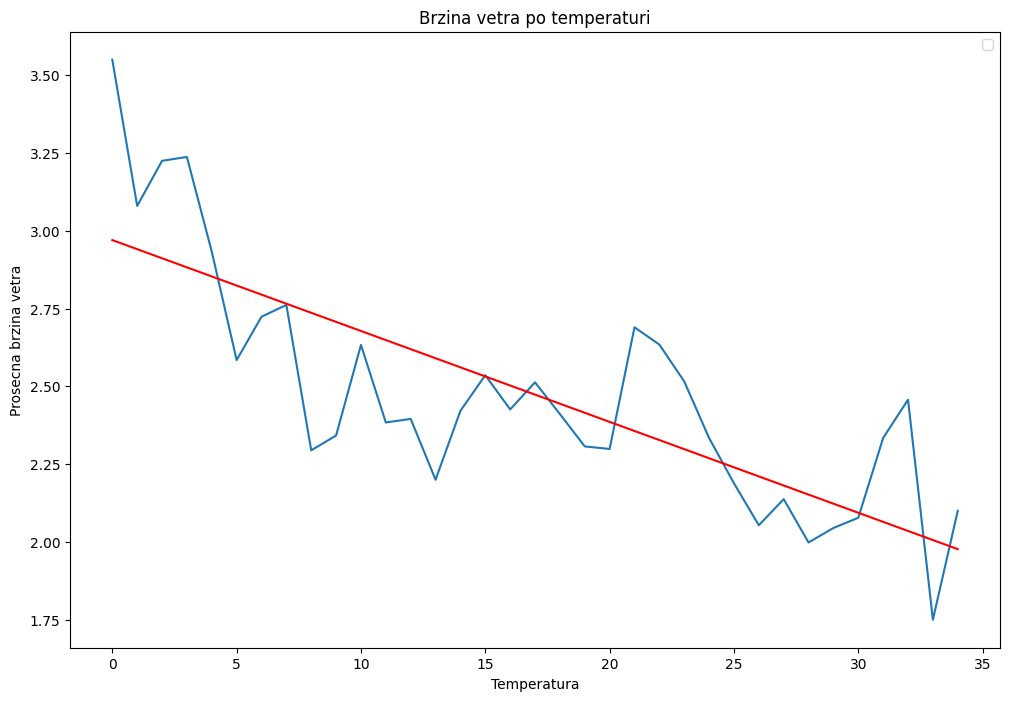

In [64]:
df = data[['T_AV', 'WSR_AV']].dropna()
df['T_bin'] = df['T_AV'].round().astype(int)

agg = df.groupby('T_bin')['WSR_AV'].mean().reset_index()

plt.plot(agg['T_bin'], agg['WSR_AV'])
m, b = np.polyfit(agg['T_bin'], agg['WSR_AV'], 1)
plt.plot(agg['T_bin'], m*agg['T_bin'] + b, color='red')

plt.xlabel('Temperatura')
plt.ylabel('Prosecna brzina vetra')
plt.title('Brzina vetra po temperaturi')
plt.legend()
plt.show()


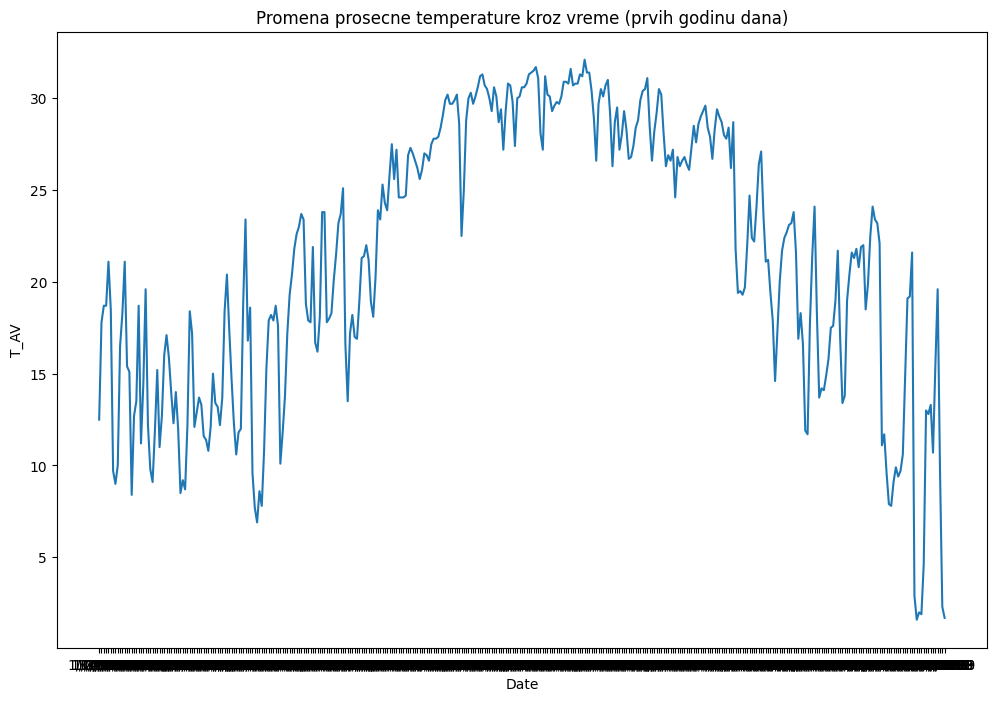

In [65]:
sns.lineplot(data=data.head(365), x='Date', y='T_AV')
plt.title('Promena prosecne temperature kroz vreme (prvih godinu dana)')
plt.show()


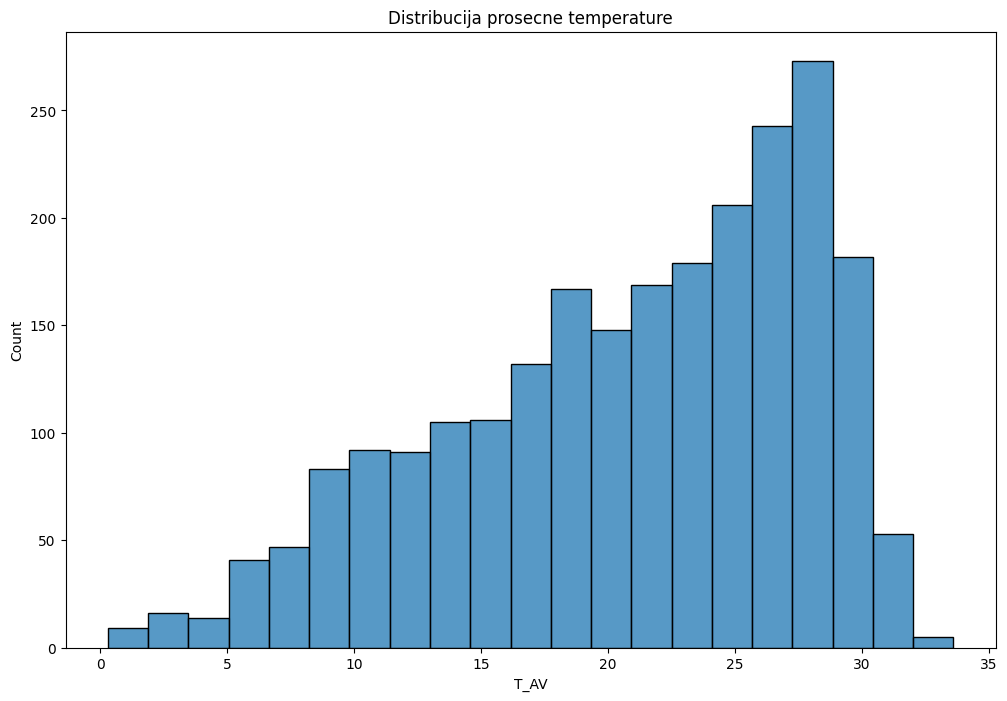

In [66]:
sns.histplot(data['T_AV'])
plt.title('Distribucija prosecne temperature')
plt.show()


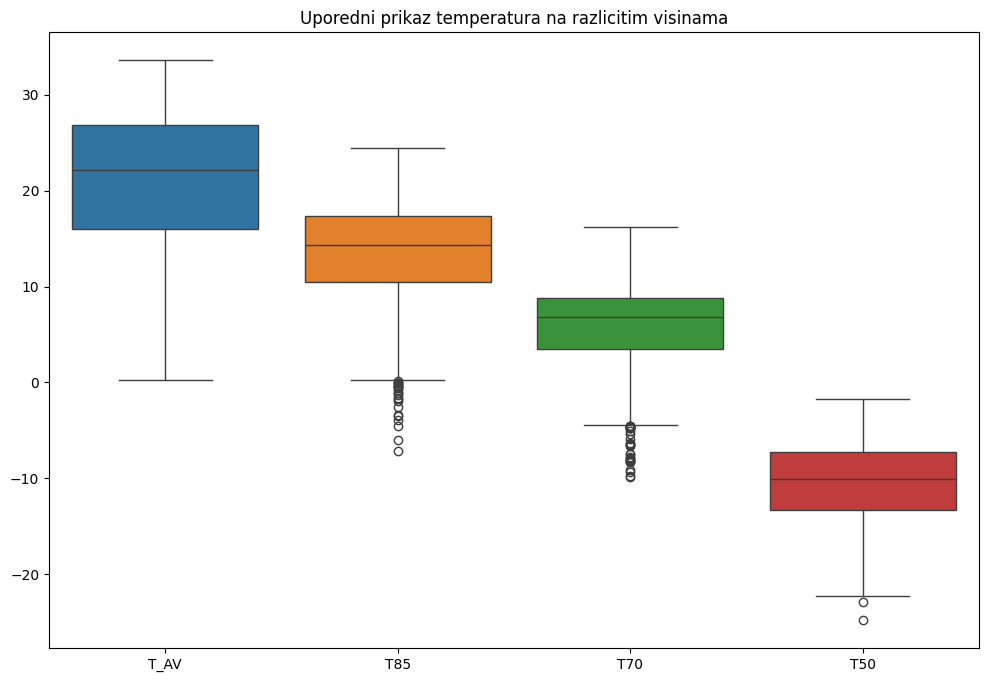

In [67]:
sns.boxplot(data=data[['T_AV', 'T85', 'T70', 'T50']])
plt.title('Uporedni prikaz temperatura na razlicitim visinama')
plt.show()


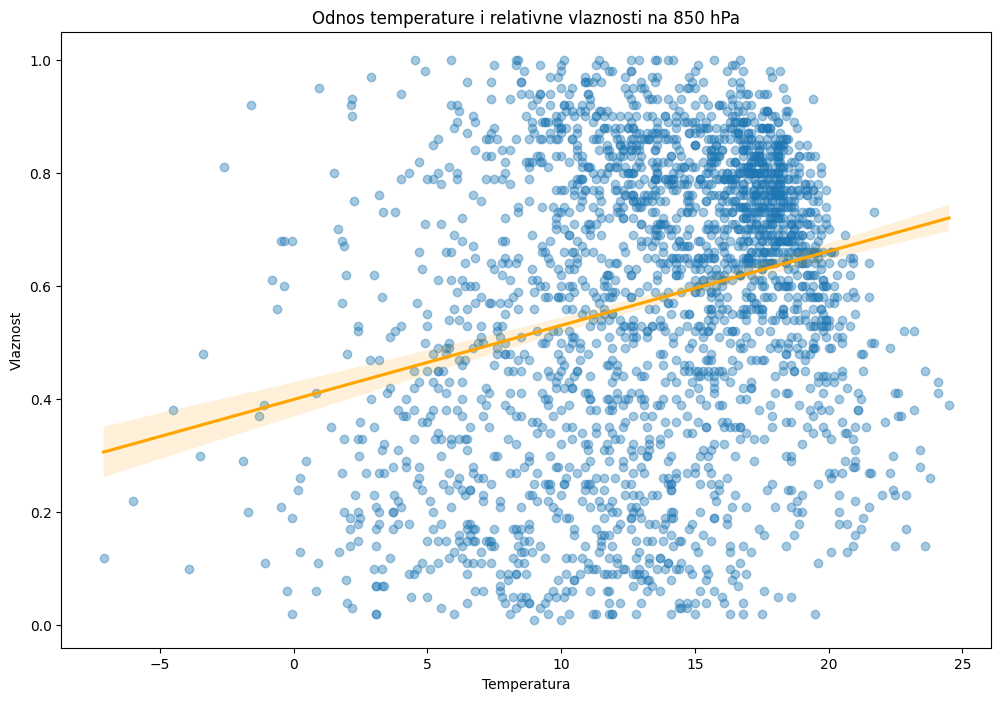

In [68]:
sns.regplot(data=data, x='T85', y='RH85', scatter_kws={'alpha':0.4}, line_kws={'color':'orange'})
plt.title('Odnos temperature i relativne vlaznosti na 850 hPa')
plt.xlabel('Temperatura')
plt.ylabel('Vlaznost')
plt.show()


Pogled koje su vrednosti NA, umesto njih stavljamo medianu, pa opet check -> vise nema NA vrednosti.

In [69]:
print(data.isna().sum().to_string())
data = data.fillna(data.median(numeric_only=True))
print(data.isna().sum().to_string())


Date        0
WSR0      299
WSR1      292
WSR2      294
WSR3      292
WSR4      293
WSR5      292
WSR6      291
WSR7      289
WSR8      290
WSR9      287
WSR10     288
WSR11     292
WSR12     287
WSR13     288
WSR14     288
WSR15     286
WSR16     284
WSR17     283
WSR18     286
WSR19     292
WSR20     294
WSR21     293
WSR22     300
WSR23     297
WSR_PK    273
WSR_AV    273
T0        190
T1        185
T2        187
T3        184
T4        184
T5        183
T6        183
T7        183
T8        185
T9        185
T10       188
T11       192
T12       189
T13       191
T14       192
T15       187
T16       184
T17       182
T18       184
T19       188
T20       189
T21       185
T22       192
T23       189
T_PK      175
T_AV      175
T85        99
RH85      105
U85       180
V85       180
HT85       95
T70       107
RH70      115
U70       157
V70       157
HT70      100
T50       115
RH50      125
U50       210
V50       210
HT50      112
KI        136
TT        125
SLP        95
SLP_  

odbacujemo date i class posto nisu brojevni podaci, ostale spremamo za skaliranje

In [70]:

# Kolone koje skaliramo: sve osim Date i Class
feature_cols = data.columns.drop(["Date", "Class"])

feature_cols


Index(['WSR0', 'WSR1', 'WSR2', 'WSR3', 'WSR4', 'WSR5', 'WSR6', 'WSR7', 'WSR8',
       'WSR9', 'WSR10', 'WSR11', 'WSR12', 'WSR13', 'WSR14', 'WSR15', 'WSR16',
       'WSR17', 'WSR18', 'WSR19', 'WSR20', 'WSR21', 'WSR22', 'WSR23', 'WSR_PK',
       'WSR_AV', 'T0', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9',
       'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 'T16', 'T17', 'T18', 'T19',
       'T20', 'T21', 'T22', 'T23', 'T_PK', 'T_AV', 'T85', 'RH85', 'U85', 'V85',
       'HT85', 'T70', 'RH70', 'U70', 'V70', 'HT70', 'T50', 'RH50', 'U50',
       'V50', 'HT50', 'KI', 'TT', 'SLP', 'SLP_', 'Precp'],
      dtype='object')

Skalirani podaci

In [ ]:
scaler = StandardScaler()

X_scaled = scaler.fit_transform(data[feature_cols])

data_scaled = pd.DataFrame(X_scaled, columns=feature_cols)

data_scaled["Class"] = data["Class"].values

data_scaled.head()



,WSR0,WSR1,WSR2,WSR3,WSR4,WSR5,WSR6,WSR7,WSR8,WSR9,...,RH50,U50,V50,HT50,KI,TT,SLP,SLP_,Precp,Class
0,-0.667611,0.205543,0.763114,0.527147,0.445105,0.529379,-0.101229,-0.303127,-0.569843,-0.472311,...,-0.620519,0.093787,-0.334139,-0.317611,-1.132855,-1.792524,3.228129,-1.582570,-0.282090,0.0
1,0.999280,1.376907,1.531717,1.055266,1.596205,1.524699,1.176882,0.702946,0.505597,0.484313,...,0.735674,-0.156056,0.432751,-0.188551,0.163823,-0.781050,2.158413,-1.582570,-0.282090,0.0
2,1.082625,1.042231,0.933914,0.527147,0.622197,0.891314,0.811708,0.611484,-0.300983,-0.298379,...,1.228835,-0.314948,1.279171,-0.382141,0.354730,0.339772,1.380438,-1.149999,-0.282090,0.0
3,2.582826,1.878920,1.873318,2.023485,1.242020,1.434216,1.085589,0.428562,-0.121743,0.223416,...,0.776771,-0.118799,1.384263,-0.575731,1.011746,1.287459,0.602463,-1.149999,1.297567,0.0
4,0.832591,0.456549,0.079911,-0.088992,-0.528903,-0.013523,-0.375111,-0.577511,-1.107563,-1.255004,...,-0.291745,-0.064557,-0.061467,0.198628,0.205971,0.321547,-0.078265,0.003525,0.158392,0.0


Pripremanje za pca, podaci za temperaturu i vetar po satu. 

In [72]:
# Satne kolone za vetar
wsr_cols = [col for col in data_scaled.columns if col.startswith("WSR") and col not in ["WSR_AV", "WSR_PK"]]

# Satne kolone za temperaturu
temp_cols = [col for col in data_scaled.columns if col.startswith("T") and col not in ["T_AV", "T_PK", "T85", "T70", "T50"]]

wsr_cols, temp_cols


(['WSR0',
  'WSR1',
  'WSR2',
  'WSR3',
  'WSR4',
  'WSR5',
  'WSR6',
  'WSR7',
  'WSR8',
  'WSR9',
  'WSR10',
  'WSR11',
  'WSR12',
  'WSR13',
  'WSR14',
  'WSR15',
  'WSR16',
  'WSR17',
  'WSR18',
  'WSR19',
  'WSR20',
  'WSR21',
  'WSR22',
  'WSR23'],
 ['T0',
  'T1',
  'T2',
  'T3',
  'T4',
  'T5',
  'T6',
  'T7',
  'T8',
  'T9',
  'T10',
  'T11',
  'T12',
  'T13',
  'T14',
  'T15',
  'T16',
  'T17',
  'T18',
  'T19',
  'T20',
  'T21',
  'T22',
  'T23',
  'TT'])

PCA za WSR0 - WSR23(brzinu vetra)

In [73]:

pca_wsr = PCA(n_components=2)
wsr_components = pca_wsr.fit_transform(data_scaled[wsr_cols])

print("WSR PCA explained variance:", pca_wsr.explained_variance_ratio_)

data_scaled["WSR_PC1"] = wsr_components[:,0]
data_scaled["WSR_PC2"] = wsr_components[:,1]



WSR PCA explained variance: [0.52953271 0.17537808]


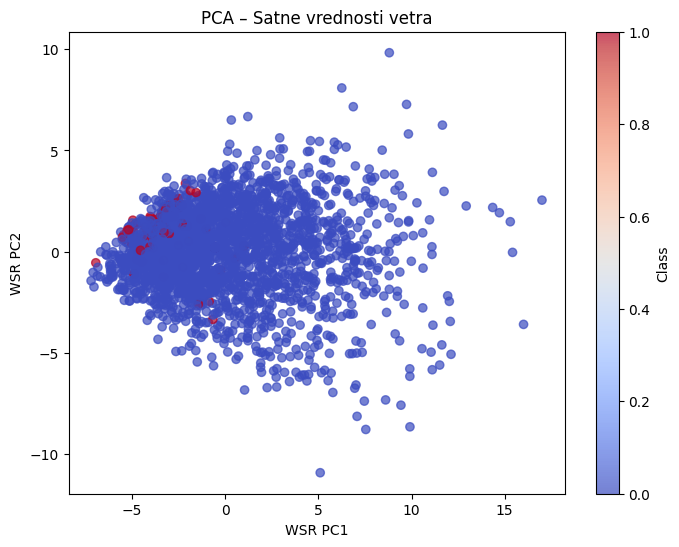

In [74]:
plt.figure(figsize=(8,6))
plt.scatter(wsr_components[:,0], wsr_components[:,1], 
            c=data_scaled["Class"], cmap="coolwarm", alpha=0.7)
plt.colorbar(label="Class")
plt.xlabel("WSR PC1")
plt.ylabel("WSR PC2")
plt.title("PCA – Satne vrednosti vetra")
plt.show()


Zakljucak za vetar: PC1 objasnjava 52.95% varijanse, PC2 17.53 varijanse -> ukupno oko 70%. Ovo ukazuje na haoticnu prirodu kretanja i same brzine vetra.

PCA za T0-T23(temperaturu)

In [75]:
pca_temp = PCA(n_components=1)
temp_components = pca_temp.fit_transform(data_scaled[temp_cols])

print("Temp PCA explained variance:", pca_temp.explained_variance_ratio_)


data_scaled["TEMP_PC1"] = temp_components[:, 0]


Temp PCA explained variance: [0.89462842]


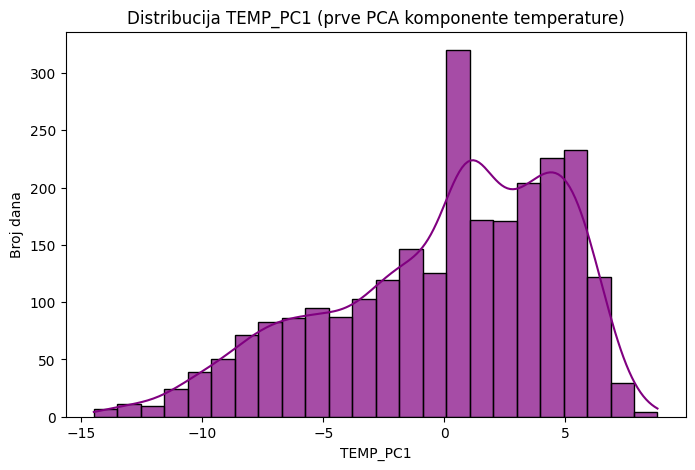

In [76]:
plt.figure(figsize=(8,5))
sns.histplot(data_scaled["TEMP_PC1"], kde=True, color="purple", alpha=0.7)
plt.title("Distribucija TEMP_PC1 (prve PCA komponente temperature)")
plt.xlabel("TEMP_PC1")
plt.ylabel("Broj dana")
plt.show()


Zakljucak za temperaturu: PC1 = 89.46%, sto nam je vec dovoljno. Temperatura tokom dana se menja koordinisano, tako da je jedna komponentna dovoljna da objasni celu prirodu toka temperature kroz dan.

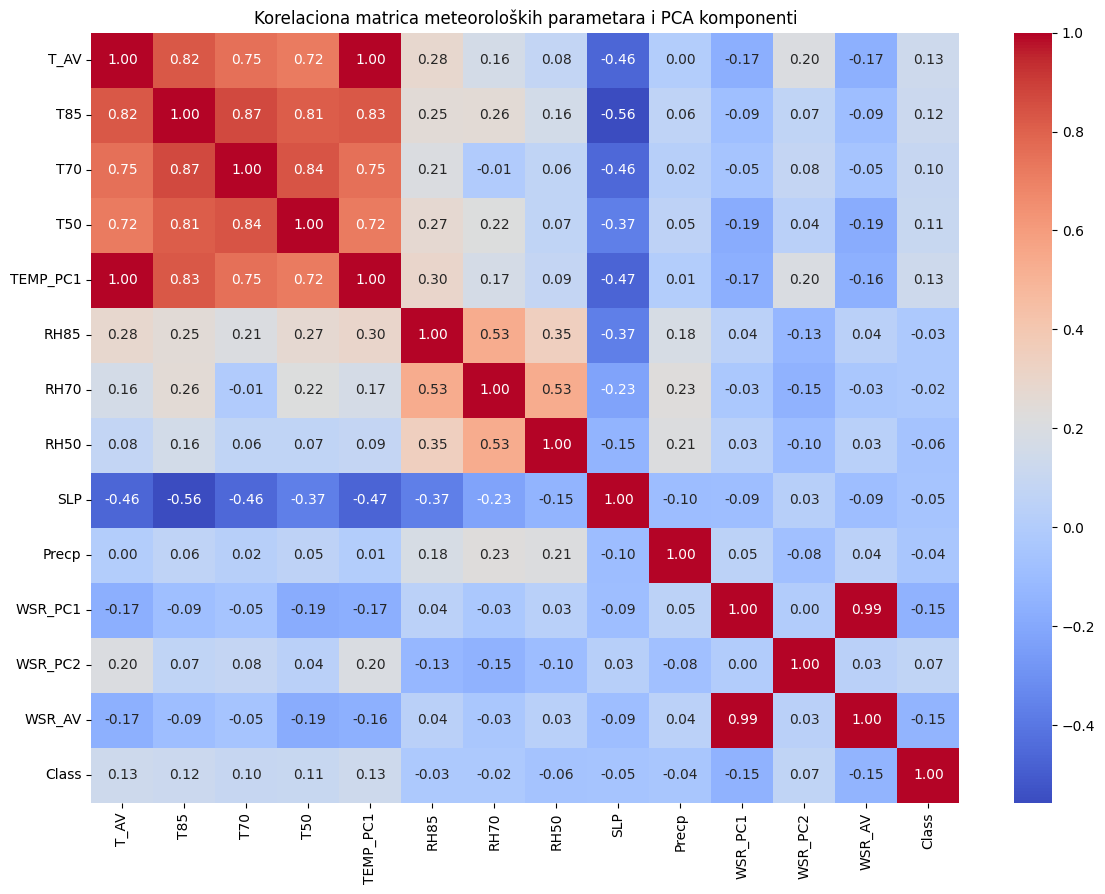

In [77]:
corr_cols = [
    # Temperature
    "T_AV", "T85", "T70", "T50", "TEMP_PC1",

    # Vlažnost
    "RH85", "RH70", "RH50",

    # Pritisak / padavine
    "SLP", "Precp",

    # Vetar PCA
    "WSR_PC1", "WSR_PC2",

    # Agregat vetra
    "WSR_AV",

    # Target
    "Class"
]

plt.figure(figsize=(14,10))
sns.heatmap(data_scaled[corr_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Korelaciona matrica meteoroloških parametara i PCA komponenti")
plt.show()


Gledamo da li prati normalnu distribuciju kolone poput temperature, brzine vetra, vlaznosti vazduha.

In [78]:
from scipy.stats import shapiro

cols_to_test = ["TEMP_PC1", "T_AV", "WSR_PC1", "WSR_AV", "RH85", "SLP"]

for col in cols_to_test:
    stat, p = shapiro(data_scaled[col].dropna())
    print(f"{col}: p-value = {p:.5f}")


TEMP_PC1: p-value = 0.00000
T_AV: p-value = 0.00000
WSR_PC1: p-value = 0.00000
WSR_AV: p-value = 0.00000
RH85: p-value = 0.00000
SLP: p-value = 0.00000


Ne prati normalnu distribuciju, pa radimo Mann-Whitney U-test.

In [79]:
from scipy.stats import mannwhitneyu

tests = {
    "TEMP_PC1": "Temperatura (PCA)",
    "WSR_PC1": "Vetar (PCA)",
    "RH85": "Vlažnost",
    "SLP": "Pritisak"
}

class0 = data_scaled[data_scaled["Class"] == 0]
class1 = data_scaled[data_scaled["Class"] == 1]

for col, label in tests.items():
    stat, p = mannwhitneyu(class0[col], class1[col], alternative='two-sided')
    print(f"{label} - {col}: p-value = {p:.5f}")


Temperatura (PCA) - TEMP_PC1: p-value = 0.00000
Vetar (PCA) - WSR_PC1: p-value = 0.00000
Vlažnost - RH85: p-value = 0.06839
Pritisak - SLP: p-value = 0.01768


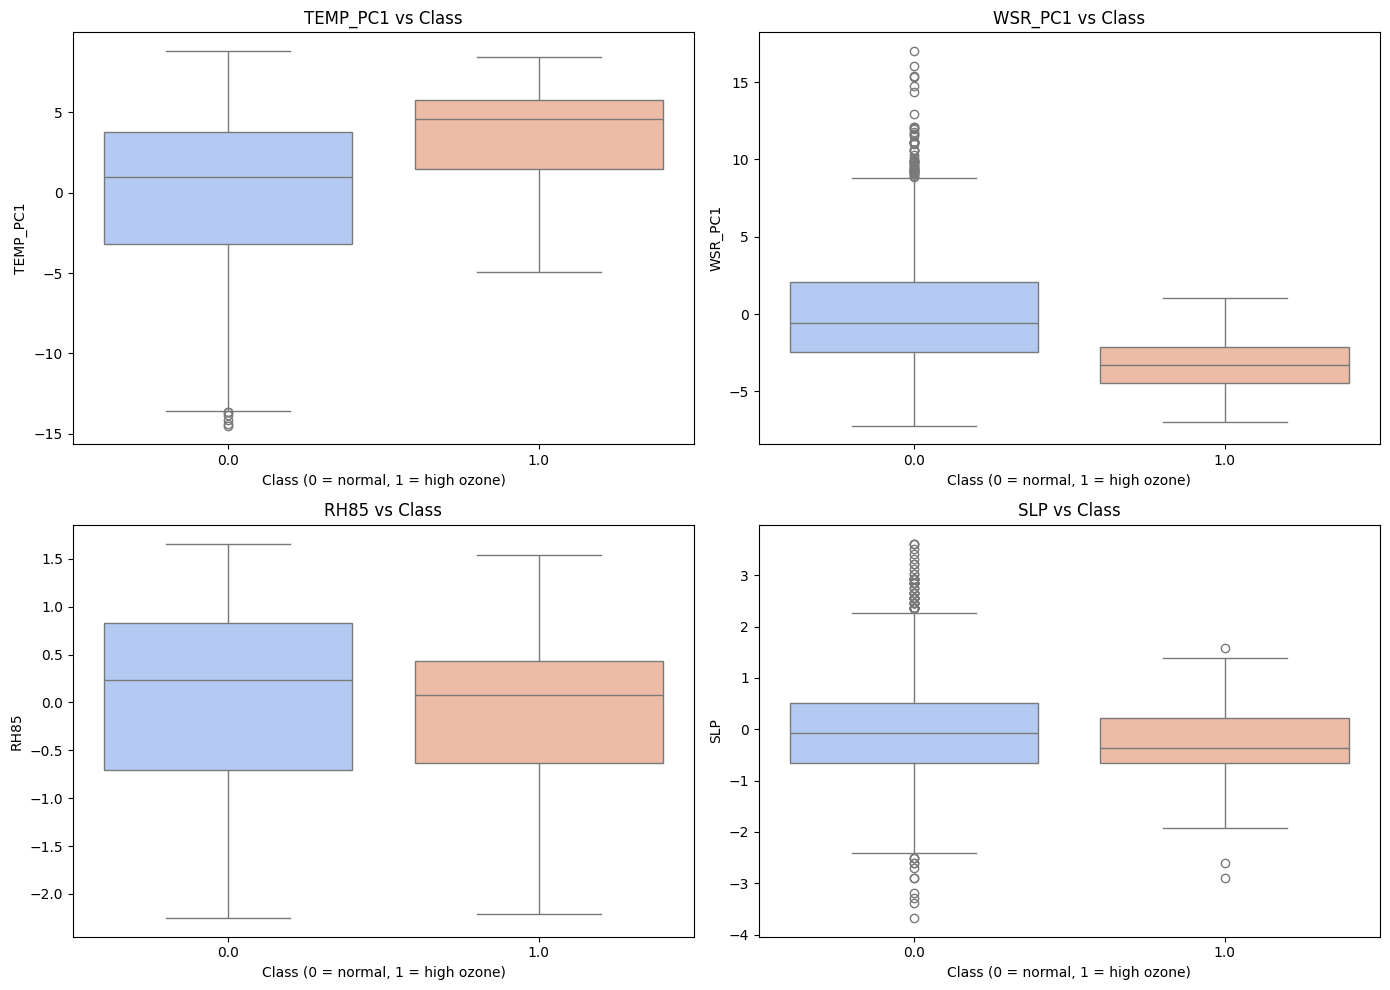

In [80]:
plt.figure(figsize=(14, 10))

# 1. TEMP_PC1
plt.subplot(2, 2, 1)
sns.boxplot(
    x="Class",
    y="TEMP_PC1",
    data=data_scaled,
    hue="Class",
    palette="coolwarm",
    dodge=False
)
plt.title("TEMP_PC1 vs Class")
plt.xlabel("Class (0 = normal, 1 = high ozone)")
plt.ylabel("TEMP_PC1")
plt.legend([],[], frameon=False)  # remove redundant legend

# 2. WSR_PC1
plt.subplot(2, 2, 2)
sns.boxplot(
    x="Class",
    y="WSR_PC1",
    data=data_scaled,
    hue="Class",
    palette="coolwarm",
    dodge=False
)
plt.title("WSR_PC1 vs Class")
plt.xlabel("Class (0 = normal, 1 = high ozone)")
plt.ylabel("WSR_PC1")
plt.legend([],[], frameon=False)

# 3. RH85
plt.subplot(2, 2, 3)
sns.boxplot(
    x="Class",
    y="RH85",
    data=data_scaled,
    hue="Class",
    palette="coolwarm",
    dodge=False
)
plt.title("RH85 vs Class")
plt.xlabel("Class (0 = normal, 1 = high ozone)")
plt.ylabel("RH85")
plt.legend([],[], frameon=False)

# 4. SLP
plt.subplot(2, 2, 4)
sns.boxplot(
    x="Class",
    y="SLP",
    data=data_scaled,
    hue="Class",
    palette="coolwarm",
    dodge=False
)
plt.title("SLP vs Class")
plt.xlabel("Class (0 = normal, 1 = high ozone)")
plt.ylabel("SLP")
plt.legend([],[], frameon=False)

plt.tight_layout()
plt.show()


Vidimo da na ozon utice: povisena temperatura, slabiji vetar, dok vlaga utice znatno manje, ako uopste.

Faza 5 

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

feature_cols = ["T_AV", "WSR_AV", "RH85", "SLP"]


X = data[feature_cols]
y = data["Class"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=2019, stratify=y
)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

print(f"Trening set oblika: {X_train.shape}")
print(f"Test set oblika: {X_test.shape}")



Trening set oblika: (1775, 4)
Test set oblika: (761, 4)


Logisticka regresija

In [ ]:
log_model = LogisticRegression(random_state=2019, max_iter=1000, class_weight="balanced")
log_model.fit(X_train_scaled, y_train)
y_pred_log = log_model.predict(X_test_scaled)

SVM

In [ ]:
svm_model = SVC(kernel="linear", C=1, random_state=2019, class_weight="balanced")
svm_model.fit(X_train_scaled, y_train)
y_pred_svm = svm_model.predict(X_test_scaled)

--- Evaluacija: Logistička regresija (Holdout) ---
                precision    recall  f1-score   support

    Normal (0)       0.99      0.76      0.86       739
High Ozone (1)       0.09      0.82      0.17        22

      accuracy                           0.76       761
     macro avg       0.54      0.79      0.51       761
  weighted avg       0.97      0.76      0.84       761



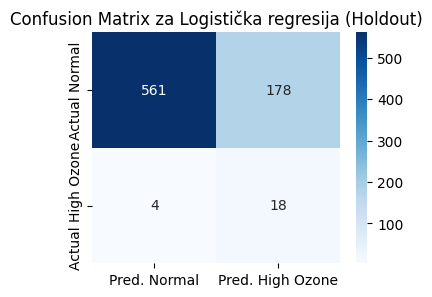

--- Evaluacija: SVM (Linear) (Holdout) ---
                precision    recall  f1-score   support

    Normal (0)       0.99      0.74      0.85       739
High Ozone (1)       0.08      0.82      0.15        22

      accuracy                           0.74       761
     macro avg       0.54      0.78      0.50       761
  weighted avg       0.97      0.74      0.83       761



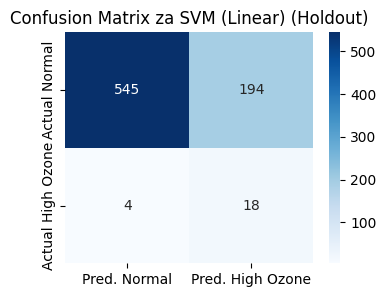


=== HOLDOUT (bez cross-validation) ===
                         Model  Accuracy  Precision_1  Recall_1  F1_Score_1
Logistička regresija (Holdout)  0.760841     0.091837  0.818182    0.165138
        SVM (Linear) (Holdout)  0.739816     0.084906  0.818182    0.153846


In [ ]:

evaluate_model(y_test, y_pred_log, "Logistička regresija (Holdout)")
evaluate_model(y_test, y_pred_svm, "SVM (Linear) (Holdout)")

comparison_holdout = pd.DataFrame({
    'Model': ['Logistička regresija (Holdout)', 'SVM (Linear) (Holdout)'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_log),
        accuracy_score(y_test, y_pred_svm)
    ],
    'Precision_1': [
        precision_score(y_test, y_pred_log, pos_label=1, zero_division=0),
        precision_score(y_test, y_pred_svm, pos_label=1, zero_division=0)
    ],
    'Recall_1': [
        recall_score(y_test, y_pred_log, pos_label=1, zero_division=0),
        recall_score(y_test, y_pred_svm, pos_label=1, zero_division=0)
    ],
    'F1_Score_1': [
        f1_score(y_test, y_pred_log, pos_label=1, zero_division=0),
        f1_score(y_test, y_pred_svm, pos_label=1, zero_division=0)
    ]
})

print("\n=== HOLDOUT ===")
print(comparison_holdout.to_string(index=False))




Modeli su prepoznali da je važnije uhvatiti slučajeve povišenog ozona (High Ozone) - class_weight = balanced, pa su češće označavali uzorke kao High Ozone čak i kada to nisu. Zbog toga je preciznost za klasu 1 niska (Precision: 0.09), jer veliki deo predikcija “High Ozone” zapravo pripada klasi “Normal” (mnogo lažno pozitivnih). S druge strane, prednost ovakvog ponašanja je visok odziv (Recall: 0.81), što znači da model uspešno detektuje većinu stvarnih slučajeva povišenog ozona i retko ih propušta.

Generalno ne postoji velika razlika izmedju ova 2 modela.

Faza 6

Decision tree

--- Evaluacija: Decision Tree (balanced, depth=5) ---
                precision    recall  f1-score   support

    Normal (0)       0.98      0.83      0.90       739
High Ozone (1)       0.08      0.50      0.14        22

      accuracy                           0.82       761
     macro avg       0.53      0.66      0.52       761
  weighted avg       0.96      0.82      0.88       761



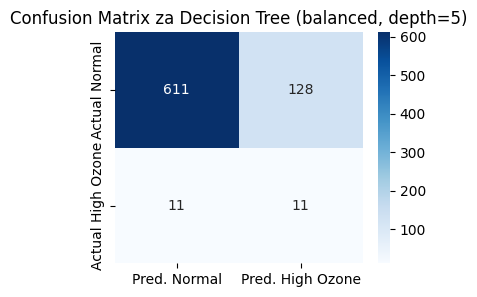

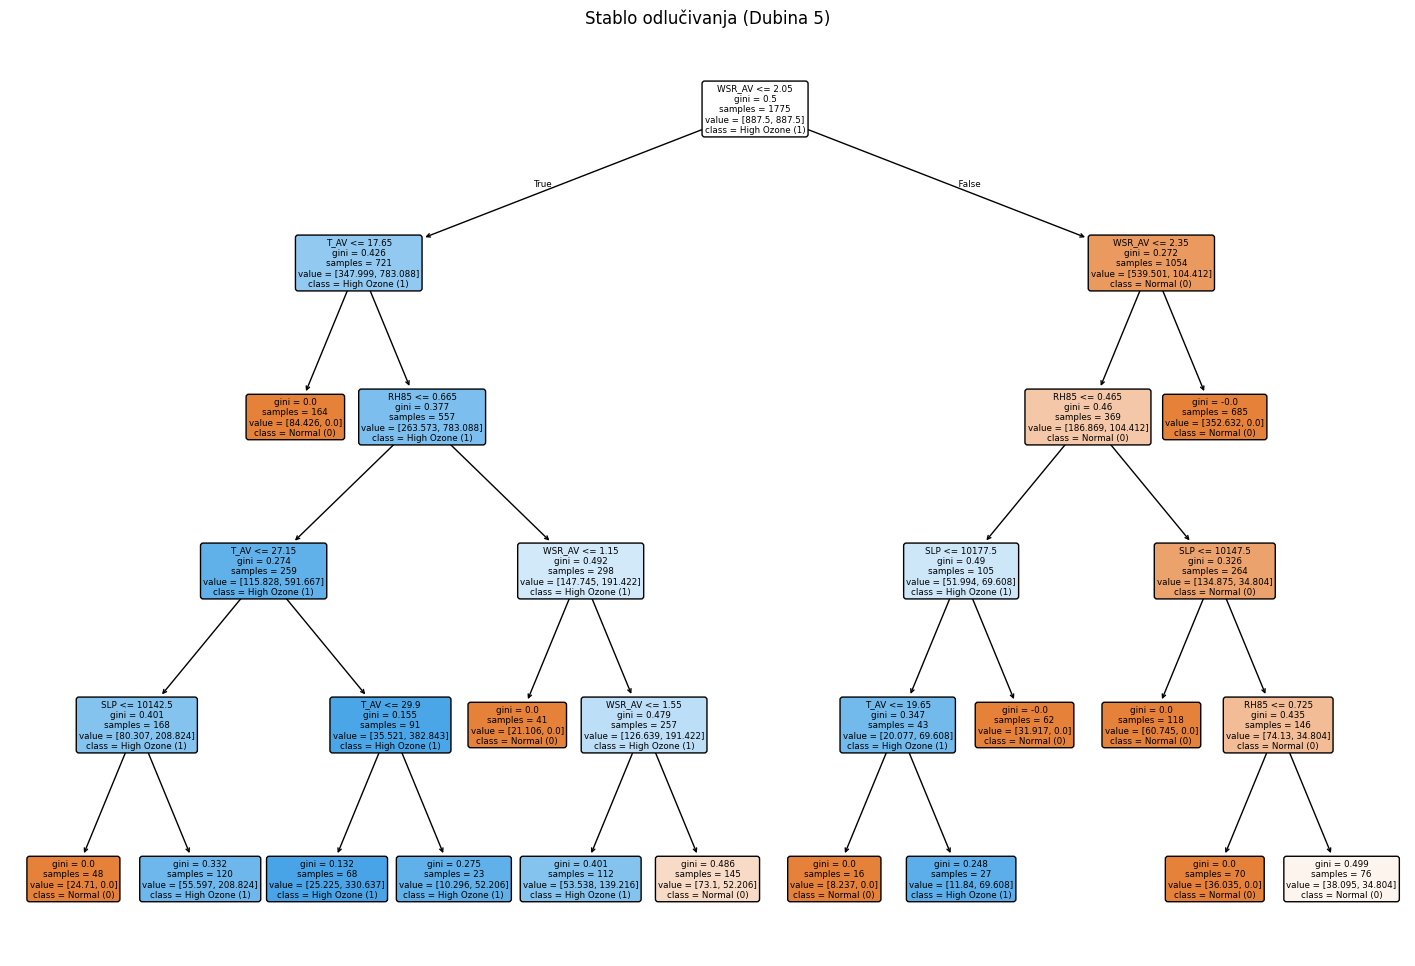

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt_model_bal = DecisionTreeClassifier(
    random_state=2019,
    class_weight="balanced",
    max_depth=5
)
dt_model_bal.fit(X_train, y_train)

y_pred_dt_bal = dt_model_bal.predict(X_test)


evaluate_model(y_test, y_pred_dt_bal, "Decision Tree (balanced, depth=5)")

plt.figure(figsize=(18, 12))
plot_tree(dt_model_bal, 
          filled=True, 
          feature_names=X_train.columns.tolist(), 
          class_names=['Normal (0)', 'High Ozone (1)'],
          rounded=True)
plt.title("Stablo odlučivanja (Dubina 5)")
plt.show()

Neuronska mreza 

--- Evaluacija: Perceptron (scaled) ---
                precision    recall  f1-score   support

    Normal (0)       0.98      0.88      0.93       739
High Ozone (1)       0.12      0.55      0.20        22

      accuracy                           0.87       761
     macro avg       0.55      0.71      0.57       761
  weighted avg       0.96      0.87      0.91       761



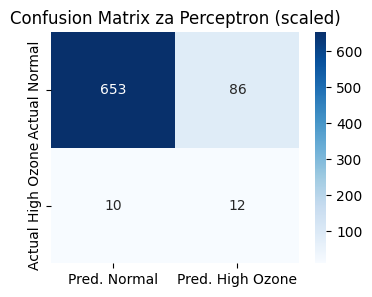

In [ ]:
from sklearn.linear_model import Perceptron


perceptron_model = Perceptron(
    max_iter=2000,
    random_state=2019,
    class_weight="balanced" 
)

perceptron_model.fit(X_train_scaled, y_train)

y_pred_perceptron = perceptron_model.predict(X_test_scaled)

evaluate_model(y_test, y_pred_perceptron, "Perceptron (scaled)")


K-means

In [124]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

kmeans = KMeans(n_clusters=2, random_state=2019, n_init=10)

kmeans.fit(X_train_scaled)
clusters_test = kmeans.predict(X_test_scaled)

cluster_vs_class = pd.crosstab(y_test, clusters_test, rownames=["Actual Class"], colnames=["Cluster"])
print("\n### Poređenje K-Means klastera sa stvarnom klasom (TEST) ###")
print(cluster_vs_class)




### Poređenje K-Means klastera sa stvarnom klasom (TEST) ###
Cluster         0    1
Actual Class          
0.0           232  507
1.0             6   16


class_weight: {0: 0.5147911832946636, 1: 17.401960784313726}


c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


--- Evaluacija: ANN (Backprop, 2x16 ReLU, class_weight) ---
                precision    recall  f1-score   support

    Normal (0)       0.99      0.80      0.88       739
High Ozone (1)       0.10      0.73      0.17        22

      accuracy                           0.80       761
     macro avg       0.54      0.76      0.53       761
  weighted avg       0.96      0.80      0.86       761



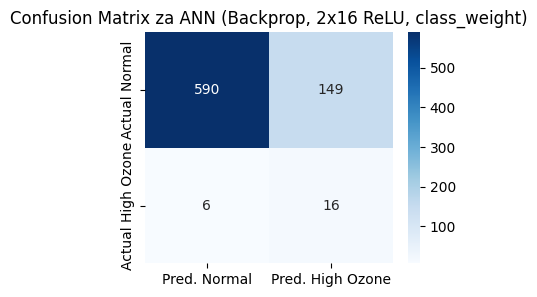

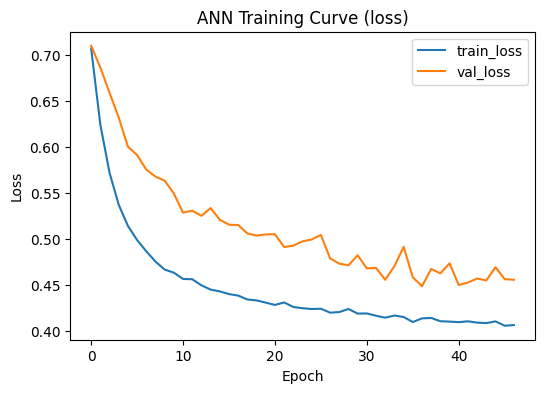

In [125]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

Xtr = np.asarray(X_train_scaled)
Xte = np.asarray(X_test_scaled)
ytr = np.asarray(y_train).astype(int)
yte = np.asarray(y_test).astype(int)

classes = np.array([0, 1])
cw = compute_class_weight(class_weight="balanced", classes=classes, y=ytr)
class_weight = {0: float(cw[0]), 1: float(cw[1])}
print("class_weight:", class_weight)

ann = Sequential()
ann.add(Dense(16, activation="relu", input_shape=(Xtr.shape[1],)))
ann.add(Dense(16, activation="relu"))
ann.add(Dense(1, activation="sigmoid"))

ann.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

es = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

history = ann.fit(
    Xtr, ytr,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    callbacks=[es],
    class_weight=class_weight,
    verbose=0
)

y_prob_ann = ann.predict(Xte, verbose=0).ravel()
y_pred_ann = (y_prob_ann >= 0.5).astype(int)

evaluate_model(yte, y_pred_ann, "ANN (Backprop, 2x16 ReLU, class_weight)")

plt.figure(figsize=(6, 4))
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("ANN Training Curve (loss)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


Poredjenje

In [ ]:
models = [
    ("Logistička regresija", y_pred_log),
    ("SVM (linear)", y_pred_svm),
    ("Decision Tree (balanced, depth=5)", y_pred_dt_bal),
    ("Perceptron", y_pred_perceptron),
    ("ANN (Backprop)", y_pred_ann),
]


rows = []
for name, y_pred in models:
    rows.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision_1": precision_score(y_test, y_pred, pos_label=1, zero_division=0),
        "Recall_1": recall_score(y_test, y_pred, pos_label=1, zero_division=0),
        "F1_1": f1_score(y_test, y_pred, pos_label=1, zero_division=0),
    })

comparison_faza6 = pd.DataFrame(rows)

print("\n### Tabela poređenja modela (Faza 6) ###")
print(comparison_faza6.sort_values(by="F1_1", ascending=False).to_string(index=False))



### Tabela poređenja modela (Faza 6) ###
                            Model  Accuracy  Precision_1  Recall_1     F1_1
             Logistička regresija  0.760841     0.091837  0.818182 0.165138
                     SVM (linear)  0.739816     0.084906  0.818182 0.153846
Decision Tree (balanced, depth=5)  0.817346     0.079137  0.500000 0.136646
                   ANN (Backprop)  0.734560     0.071429  0.681818 0.129310
                       Perceptron  0.429698     0.048246  1.000000 0.092050


Rezultati iz Tabele potvrđuju da kod neuravnoteženog skupa podataka izbor modela direktno utiče na kompromis između ukupne tačnosti i sposobnosti detekcije povišenog ozona. Nakon uvođenja class_weight='balanced', logistička regresija i linearni SVM daju gotovo identične rezultate: postižu vrlo visok recall za klasu povišenog ozona, ali uz veoma nizak precision, što dovodi do relativno malog F1-score-a (veliki broj lažno pozitivnih predikcija).

Stablo odlučivanja pokazuje drugačiji obrazac: ostvaruje stabilniji kompromis i bolju ukupnu tačnost, ali uz niži recall, pa deo stvarnih High Ozone slučajeva ostaje neprepoznat.

ANN (backpropagation) postiže umeren recall i rezultate slične linearnim modelima, ali bez jasne dominacije, što ukazuje da sa ograničenim brojem feature-a i izraženim disbalansom ne donosi značajno bolje razdvajanje klasa.

Perceptron se pokazao najmanje efikasnim, jer iako može da postigne visok recall, to dolazi uz vrlo nizak precision i pad tačnosti, što znači da prečesto označava normalne slučajeve kao povišen ozon.

Faza 7

In [37]:

data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
data = data.set_index('Date')
data = data.sort_index()

print(data.index[:5])
print(data.shape)


KeyError: 'Date'

In [38]:
# Pravljenje mesecne serije srednjih temperatura
ts_temp = data['T_AV'].resample('M').mean()

print(ts_temp.head())

Date
1998-01-31    14.574194
1998-02-28    13.396429
1998-03-31    15.964516
1998-04-30    19.513333
1998-05-31    26.458065
Freq: ME, Name: T_AV, dtype: float64


C:\Users\User\AppData\Local\Temp\ipykernel_16208\1023416976.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts_temp = data['T_AV'].resample('M').mean()


In [41]:
ts_temp = ts_temp.asfreq('M')
ts_temp = ts_temp.groupby(ts_temp.index.month).transform(
    lambda x: x.fillna(x.mean())
)


C:\Users\User\AppData\Local\Temp\ipykernel_16208\3347640747.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts_temp = ts_temp.asfreq('M')


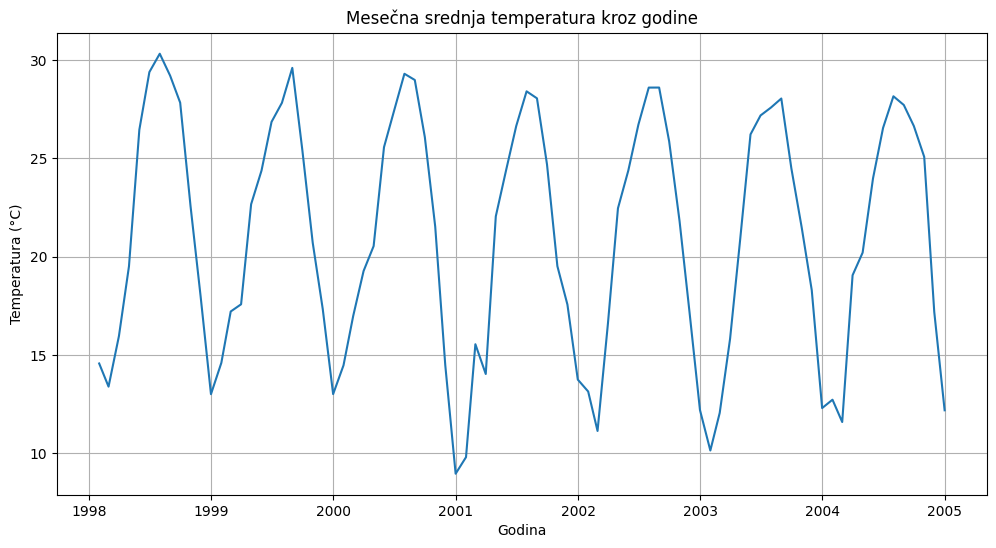

In [42]:

plt.figure(figsize=(12,6))
plt.plot(ts_temp)
plt.title('Mesečna srednja temperatura kroz godine')
plt.xlabel('Godina')
plt.ylabel('Temperatura (°C)')
plt.grid(True)
plt.show()


In [43]:
!pip install statsmodels


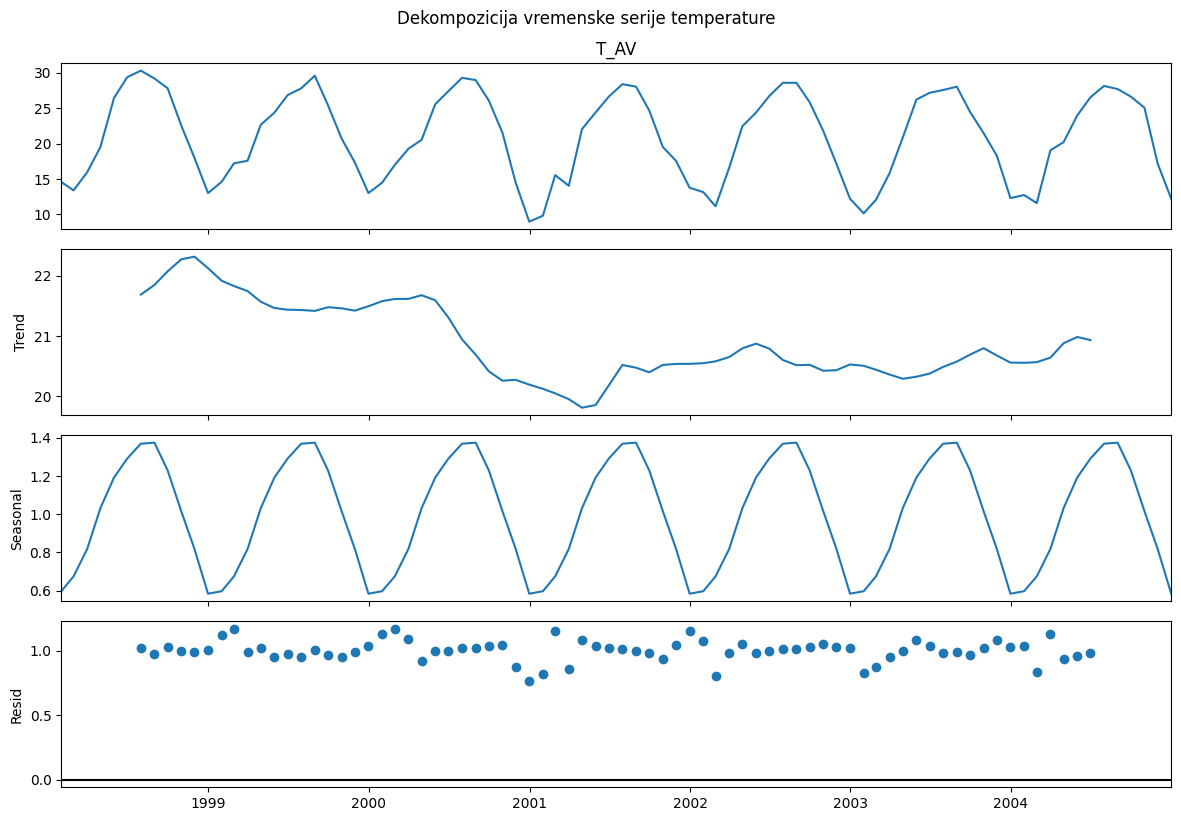

In [44]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

decomp = seasonal_decompose(ts_temp, model='multiplicative', period=12)

plt.rcParams["figure.figsize"] = (12,8)
decomp.plot()
plt.suptitle("Dekompozicija vremenske serije temperature", y=1.02)
plt.show()


In [45]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series, name):
    print(f"--- ADF Test: {name} ---")
    result = adfuller(series.dropna(), autolag='AIC')
    print(f"P-vrednost: {result[1]:.4f}")
    if result[1] <= 0.05:
        print("=> Serija je STACIONARNA")
    else:
        print("=> Serija je NESTACIONARNA")


In [46]:
check_stationarity(ts_temp, "Originalna temperatura")

--- ADF Test: Originalna temperatura ---
P-vrednost: 0.2976
=> Serija je NESTACIONARNA


In [47]:
temp_diff1 = ts_temp.diff(1)
check_stationarity(temp_diff1, "Diferencirana serija (d=1)")

temp_stationary = temp_diff1.diff(12)
check_stationarity(temp_stationary, "Diferencirana + sezonski diferencirana (d=1, D=1)")

--- ADF Test: Diferencirana serija (d=1) ---
P-vrednost: 0.0000
=> Serija je STACIONARNA
--- ADF Test: Diferencirana + sezonski diferencirana (d=1, D=1) ---
P-vrednost: 0.0173
=> Serija je STACIONARNA


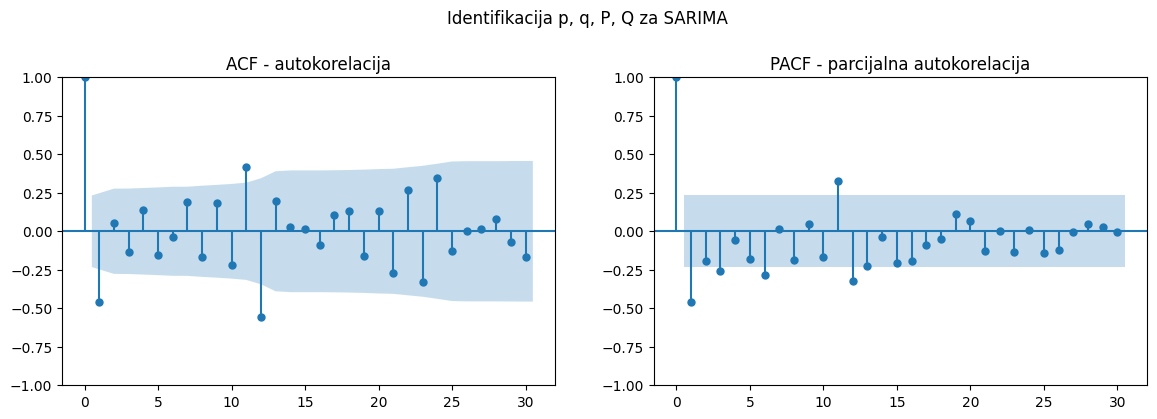

In [48]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14,4))

plot_acf(temp_stationary.dropna(), lags=30, ax=axes[0])
axes[0].set_title("ACF - autokorelacija")

plot_pacf(temp_stationary.dropna(), lags=30, ax=axes[1])
axes[1].set_title("PACF - parcijalna autokorelacija")

plt.suptitle("Identifikacija p, q, P, Q za SARIMA", y=1.05)
plt.show()


In [33]:
!pip install pmdarima


In [34]:
train_sarima = ts_temp[:'2003']
test_sarima = ts_temp['2004':]


In [49]:
from pmdarima import auto_arima

print("\nTražimo optimalan SARIMA model...")

sarima_model = auto_arima(
    train_sarima,
    seasonal=True,
    m=12,       # sezonski period
    d=1,
    D=1,
    stepwise=True,
    trace=True
)

print("\n--- Najbolji SARIMA Model ---")
sarima_model.summary()



Tražimo optimalan SARIMA model...
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=inf, Time=6.25 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=12004.232, Time=0.09 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=11503.599, Time=0.59 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=2.24 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=11998.551, Time=0.22 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=11270.796, Time=1.43 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=7.64 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=3.34 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=11280.038, Time=1.18 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=11069.303, Time=2.00 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=11296.705, Time=1.02 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=10.49 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=3.53 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=11007.179, Time=2.13 sec
 ARIM

KeyboardInterrupt: 

In [103]:
n_periods = len(test_sarima)
sarima_forecast = sarima_model.predict(n_periods=n_periods)


In [104]:
from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(test_sarima, sarima_forecast))
print("RMSE:", rmse)


RMSE: 2.00527221748944


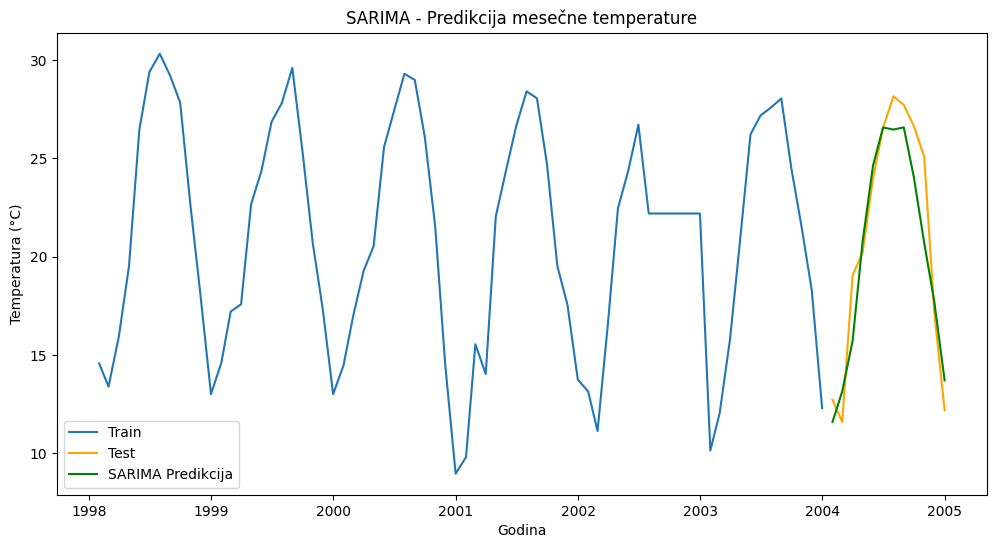

In [105]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(train_sarima, label="Train")
plt.plot(test_sarima, label="Test", color="orange")
plt.plot(test_sarima.index, sarima_forecast, label="SARIMA Predikcija", color="green")

plt.title("SARIMA - Predikcija mesečne temperature")
plt.xlabel("Godina")
plt.ylabel("Temperatura (°C)")
plt.legend()
plt.show()
